

## Классификация

SVM, LR и калибровка вероятностей 

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


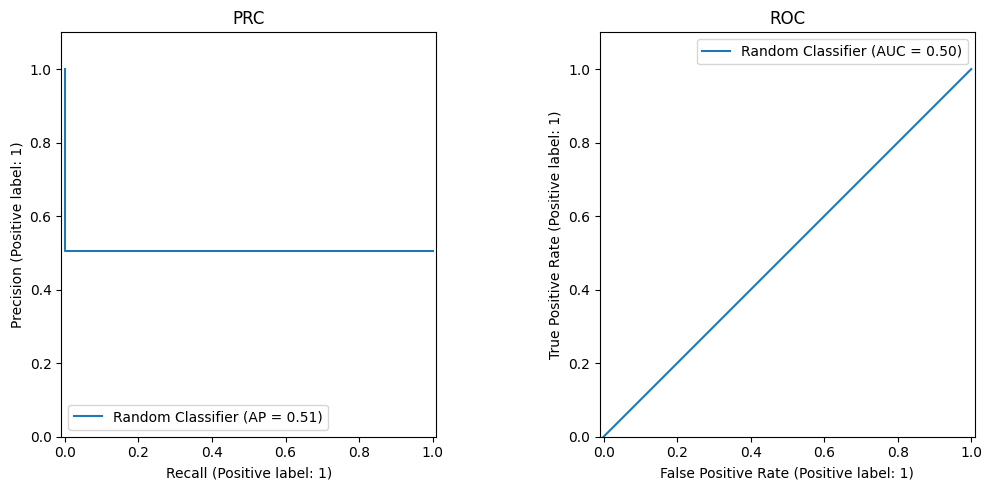

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [14]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine__



In [15]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
svc = LinearSVC(max_iter=10000, random_state=42)
grid_search = GridSearchCV(svc, param_grid, scoring='average_precision', cv=5)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
print(f"Best C: {best_C}")


svm_classifier = LinearSVC(C=best_C, max_iter=10000, random_state=42).fit(X_train, y_train)
y_svm = svm_classifier.decision_function(X_test)


Best C: 0.01


SVM Linear Kernel metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


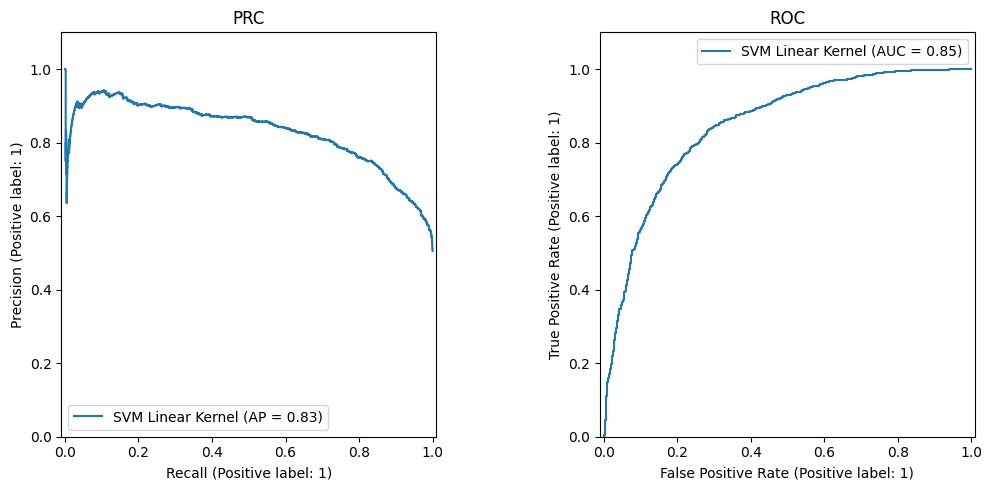

In [16]:
depict_pr_roc(y_test, y_svm, 'SVM Linear Kernel')


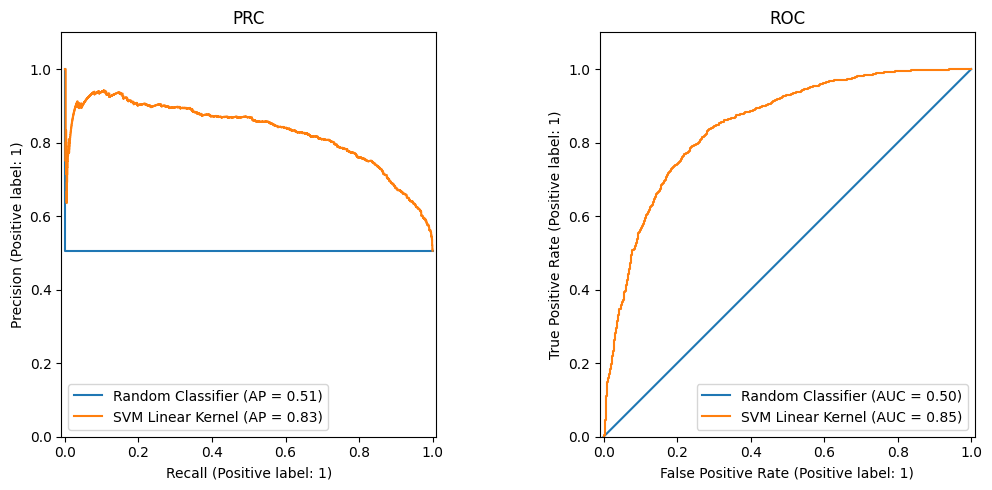

In [17]:

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_svm)
df_metrics.loc['SVM Linear Kernel'] = [
    average_precision_score(y_test, y_svm),
    roc_auc_score(y_test, y_svm),
    best_C,
]



def depict_comparison_pr_roc(y_true, y_random, y_svm, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    PrecisionRecallDisplay.from_predictions(y_true, y_random, ax=ax[0], name="Random Classifier")
    PrecisionRecallDisplay.from_predictions(y_true, y_svm, ax=ax[0], name="SVM Linear Kernel")
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_random, ax=ax[1], name="Random Classifier")
    RocCurveDisplay.from_predictions(y_true, y_svm, ax=ax[1], name="SVM Linear Kernel")
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()

depict_comparison_pr_roc(y_test, y_random, y_svm)


In [18]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.00
SVM Linear Kernel,0.829864,0.847623,0.01


SVM
 имеет значительно лучшие показатели как по AUC-ROC, так и по AUC-PR по сравнению с случайным классификатором, модель работает лучше для предсказания и различения классов.

__Logistic Regression__




In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100]}
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, scoring='average_precision', cv=5)
grid_search_logreg.fit(X_train, y_train)

best_C_logreg = grid_search_logreg.best_params_['C']
print(f"Best C for Logistic Regression: {best_C_logreg}")


logreg_classifier = LogisticRegression(C=best_C_logreg, solver='lbfgs', max_iter=10000, random_state=42).fit(X_train, y_train)
y_logreg = logreg_classifier.predict_proba(X_test)[:, 1]

precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_logreg)
df_metrics.loc['Logistic Regression'] = [
    average_precision_score(y_test, y_logreg),
    roc_auc_score(y_test, y_logreg),
    best_C_logreg,
]

Best C for Logistic Regression: 0.01


SVM Logistic Regression metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


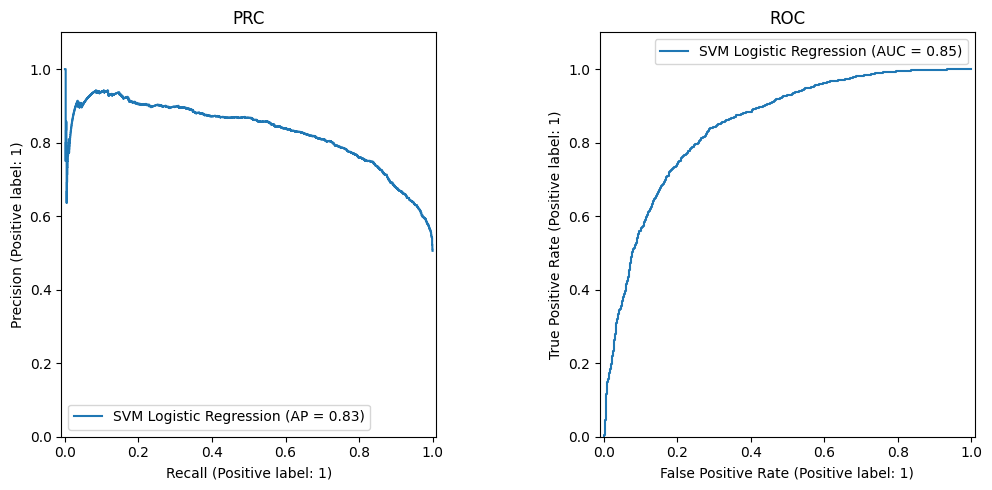

In [20]:
depict_pr_roc(y_test, y_logreg, 'SVM Logistic Regression')


In [21]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.00
SVM Linear Kernel,0.829864,0.847623,0.01
Logistic Regression,0.829930,0.847580,0.01


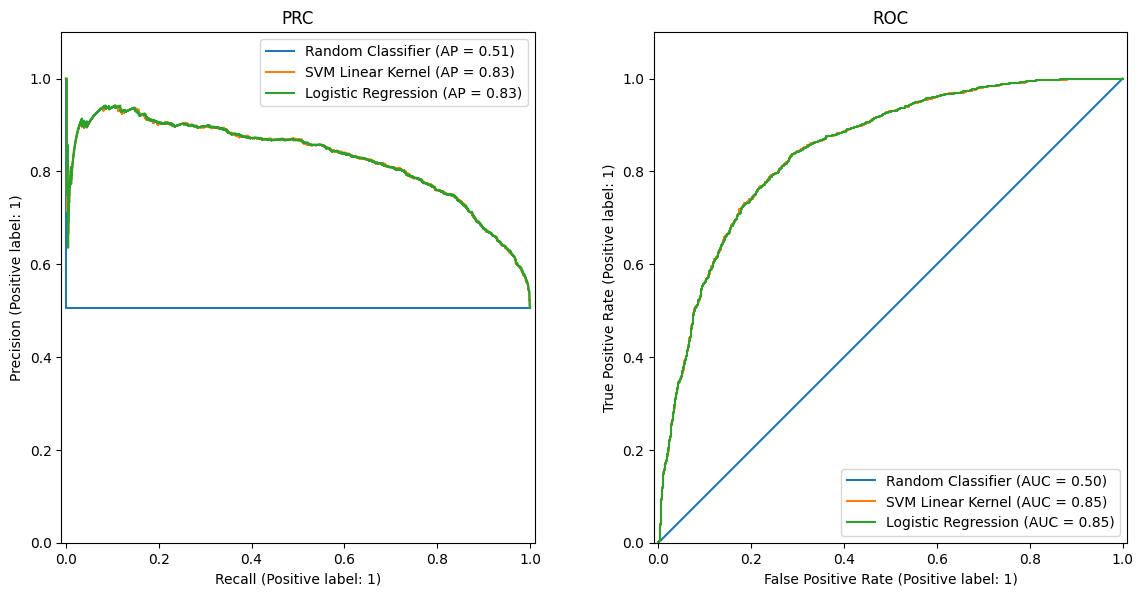

In [23]:

def plot_all_roc_pr():
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))


    PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name="Random Classifier")
    PrecisionRecallDisplay.from_predictions(y_test, y_svm, ax=ax[0], name="SVM Linear Kernel")
    PrecisionRecallDisplay.from_predictions(y_test, y_logreg, ax=ax[0], name="Logistic Regression")
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    ax[0].legend()


    RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name="Random Classifier")
    RocCurveDisplay.from_predictions(y_test, y_svm, ax=ax[1], name="SVM Linear Kernel")
    RocCurveDisplay.from_predictions(y_test, y_logreg, ax=ax[1], name="Logistic Regression")
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


plot_all_roc_pr()

 AUC-PR и AUC-ROC для SVM Linear Kernel и Logistic Regression практически одинаковы. Это говорит о том, что для этой конкретной задачи и данных оба классификатора показывают схожую производительность в терминах качества предсказания и их способности правильно классифицировать примеры.


Сгенерируем синтетические данные с помощью `make_classification` __с 2 признаками__

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, random_state=42)

model = SVC(kernel='linear', random_state=42)
model.fit(X, y)

SVC(kernel='linear', random_state=42)

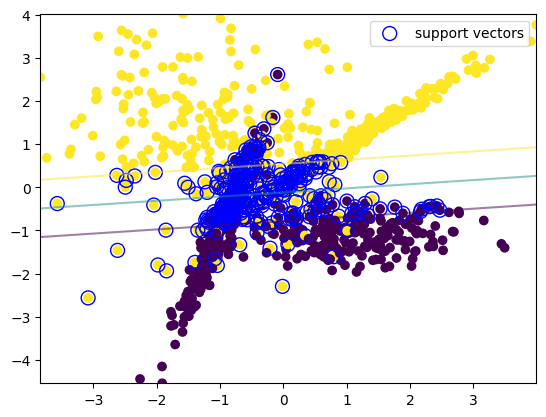

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy)
    Z = Z.reshape(XX.shape)

    plt.contour(XX, YY, Z, levels=[-1, 0, 1], alpha=0.5)

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

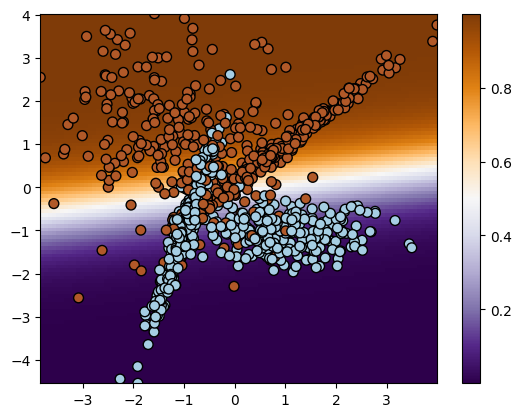

In [61]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y, edgecolors='k', s=50, cmap=plt.cm.Paired
    )

    plt.colorbar(image)

model = LogisticRegression(random_state=42)
model.fit(X, y)
plot_logreg_2D(X, y, model)



На картинке есть белая область, где оранжевый переходит к фолетовому, где модель не уверена ($p(y=+1|x) = 0.5$).

Теоретически для логистической регрессии это является решением уравнения логистической функции:

\$
p(y = +1 \mid x) = \frac{1}{1 + \exp \left( - (w^T x + b) \right)} = 0.5
\$

При решении этого уравнения, модель получает значение
\($ w^T x + b = 0 $\), что представляет собой разделяющую гиперплоскость.

__Калибровочные кривые__


In [25]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

c:\Users\vika4\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\vika4\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


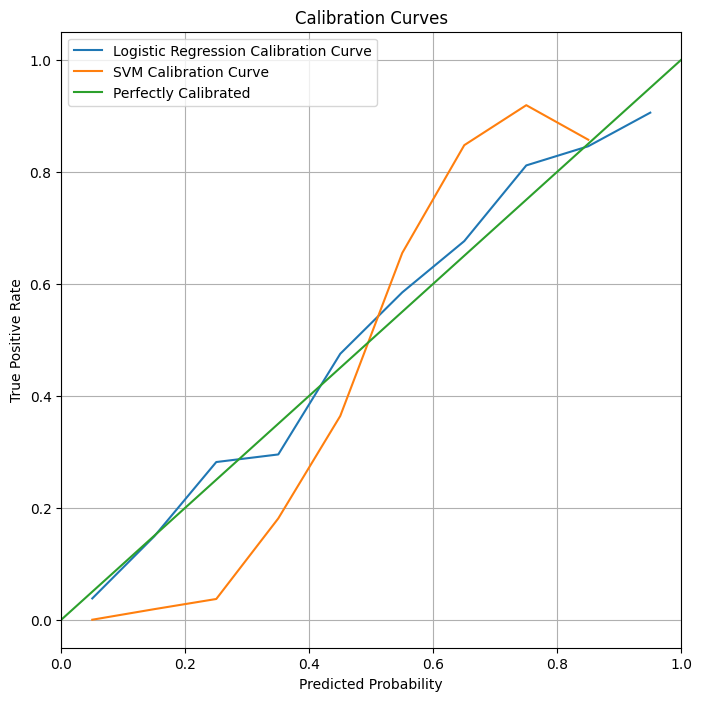

Logistic Regression AUC-PR: 0.8299300224852361
SVM AUC-PR: 0.8298637796296688


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_classifier = LinearSVC(C=0.01, max_iter=10000, random_state=42).fit(X_train, y_train)

svm_scores = svm_classifier.decision_function(X_test) 
y_svm_proba = 1 / (1 + np.exp(-svm_scores))


logreg_classifier = LogisticRegression(C=0.01, solver='lbfgs', max_iter=10000, random_state=42).fit(X_train, y_train)
y_logreg_proba = logreg_classifier.predict_proba(X_test)[:, 1] 

def plot_calibration_curve(y_test, preds, model_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))

    plt.plot(bin_middle_points, bin_real_ratios, label=f'{model_name} Calibration Curve')

plt.figure(figsize=(8, 8))

plot_calibration_curve(y_test, y_logreg_proba, 'Logistic Regression')
plot_calibration_curve(y_test, svm_proba, 'SVM')

plt.plot([0, 1], [0, 1], label='Perfectly Calibrated')

plt.xlabel('Predicted Probability')
plt.ylabel('True Positive Rate')
plt.ylim([-0.05, 1.05])
plt.xlim([0, 1])
plt.grid(True)
plt.legend()
plt.title('Calibration Curves')
plt.show()
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_logreg_proba)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_proba)

print(f"Logistic Regression AUC-PR: {average_precision_score(y_test, y_logreg_proba)}")
print(f"SVM AUC-PR: {average_precision_score(y_test, svm_proba)}")


Кривая для логистической регрессии откалибрована достаточно хорошо, а SVM не очень, так как есть значительные отклоения от диагонали.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$

In [29]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_logreg = log_loss(y_test, y_logreg_proba)
logloss_svm = log_loss(y_test, y_svm_proba)

brier_logreg = brier_score_loss(y_test, y_logreg_proba)
brier_svm = brier_score_loss(y_test, y_svm_proba)

print(f"Logistic Regression LogLoss: {logloss_logreg}")
print(f"SVM LogLoss: {logloss_svm}")
print(f"Logistic Regression Brier Score: {brier_logreg}")
print(f"SVM Brier Score: {brier_svm}")

Logistic Regression LogLoss: 0.4860186134797559
SVM LogLoss: 0.5523071960107248
Logistic Regression Brier Score: 0.15879997989011738
SVM Brier Score: 0.1832660634102191


Видно, что логистическая регрессия откалибрована хуже

Распределение ответов классификаторов

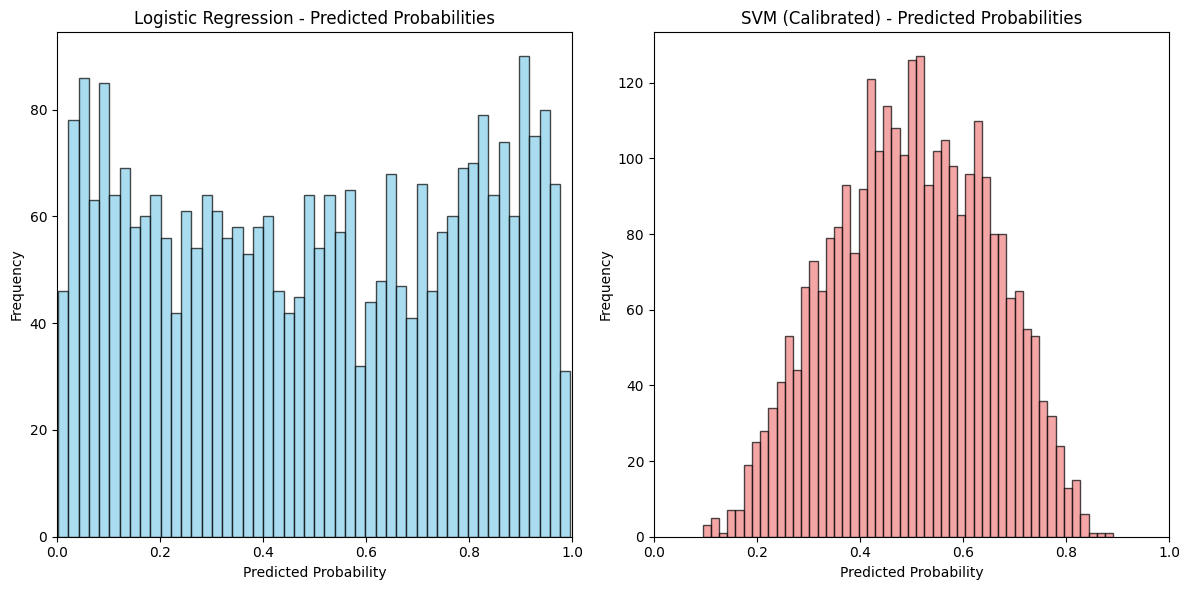

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(y_logreg_proba, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Logistic Regression - Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.xlim([0, 1])

plt.subplot(1, 2, 2)
plt.hist(svm_proba, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('SVM (Calibrated) - Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.xlim([0, 1])

plt.tight_layout()
plt.show()


гистограмма предсказанных вероятностей для логистической регрессии похожа на равномерное распределение, потому что модель напрямую оценивает вероятность принадлежности к классу с помощью логистической функции, что приводит к более сбалансированным предсказаниям. В то время как у SVM, до применения калибровки, предсказания основаны на отступах (scores), которые имеют распределение, похожее на нормальное, и только после калибровки эти отступы преобразуются в вероятности. Сигмоидная функция преобразует нормальное распределение отступов SVM в вероятности, что и приводит к виду гистограммы, напоминающему нормальное распределение.

`CalibratedClassifierCV` из `sklearn` 

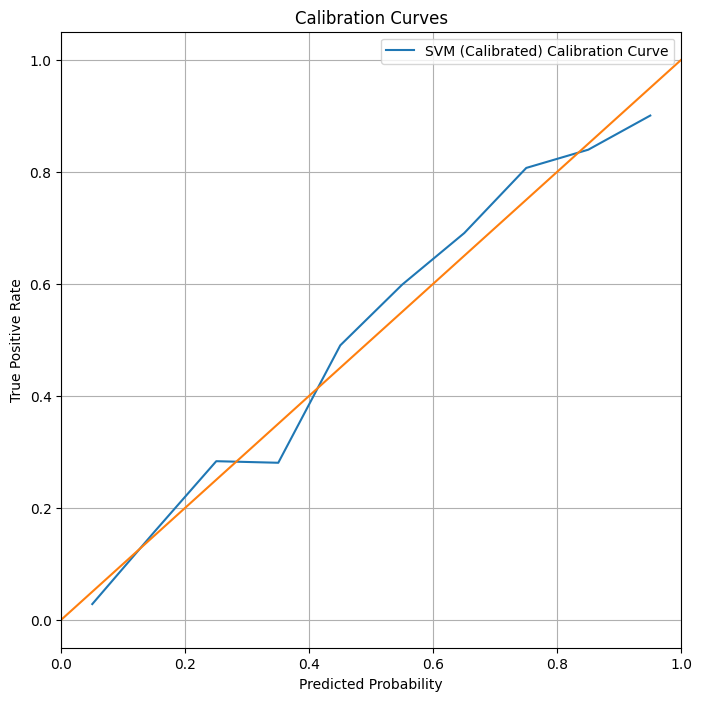

SVM AUC-PR: 0.8283396538098677


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score

X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_classifier = LinearSVC(C=0.01, max_iter=10000, random_state=42).fit(X_test, y_test)

calibrated_svm = CalibratedClassifierCV(svm_classifier, method='sigmoid', cv='prefit')
calibrated_svm.fit(X_train, y_train)
y_svm_proba = calibrated_svm.predict_proba(X_test)[:, 1]

def plot_calibration_curve(y_test, preds, model_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))

    plt.plot(bin_middle_points, bin_real_ratios, label=f'{model_name} Calibration Curve')

plt.figure(figsize=(8, 8))

plot_calibration_curve(y_test, y_svm_proba, 'SVM (Calibrated)')

plt.plot([0, 1], [0, 1])

plt.xlabel('Predicted Probability')
plt.ylabel('True Positive Rate')
plt.ylim([-0.05, 1.05])
plt.xlim([0, 1])
plt.grid(True)
plt.legend()
plt.title('Calibration Curves')
plt.show()

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_svm_proba)

print(f"SVM AUC-PR: {average_precision_score(y_test, y_svm_proba)}")


Калибровочная кривая улучшилась

#### **Обработка категориальных переменных**


Берем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/)



In [33]:
!pip install kagglehub

   ---------------------------------------- 0.0/43.0 kB ? eta -:--:--
   ---------------------------------------- 43.0/43.0 kB 1.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

c:\Users\vika4\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 22.2k/22.2k [00:00<?, ?B/s]

Extracting files...


In [35]:
import pandas as pd

df = pd.read_csv(path)
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [36]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region', 'Purchased Bike'],
      dtype='object')

In [37]:
df[categorical_columns] = df[categorical_columns].fillna('undefined')
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [38]:
X = df.drop(columns=['Purchased Bike'])
y = df['Purchased Bike']
y

0       No
1       No
2       No
3      Yes
4      Yes
      ... 
995    Yes
996    Yes
997    Yes
998     No
999    Yes
Name: Purchased Bike, Length: 1000, dtype: object

In [39]:
X

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0


In [40]:
X = X.drop(columns=['ID'])


In [41]:


X_categorical = X.select_dtypes(include=['object'])
X_numerical = X.select_dtypes(exclude=['object'])

In [42]:
X_numerical

,Income,Children,Cars,Age
0,40000.0,1.0,0.0,42.0
1,30000.0,3.0,1.0,43.0
2,80000.0,5.0,2.0,60.0
3,70000.0,0.0,1.0,41.0
4,30000.0,0.0,0.0,36.0
...,...,...,...,...
995,60000.0,2.0,2.0,54.0
996,70000.0,4.0,0.0,35.0
997,60000.0,2.0,0.0,38.0
998,100000.0,3.0,3.0,38.0


In [43]:
X_categorical

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
0,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
1,Married,Male,Partial College,Clerical,Yes,0-1 Miles,Europe
2,Married,Male,Partial College,Professional,No,2-5 Miles,Europe
3,Single,undefined,Bachelors,Professional,Yes,5-10 Miles,Pacific
4,Single,Male,Bachelors,Clerical,No,0-1 Miles,Europe
...,...,...,...,...,...,...,...
995,Married,Male,High School,Professional,Yes,2-5 Miles,North America
996,Single,Male,Graduate Degree,Professional,Yes,2-5 Miles,North America
997,Married,undefined,Bachelors,Skilled Manual,Yes,0-1 Miles,North America
998,Single,Male,Bachelors,Management,No,1-2 Miles,North America


In [44]:
y = y.map({'No': 0, 'Yes': 1})
y

0      0
1      0
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    0
999    1
Name: Purchased Bike, Length: 1000, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

**OrdinalEncoder**


In [143]:

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import time
encoder = OrdinalEncoder()

start_time = time.time()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression(max_iter=1000)


model.fit(X_train_encoded, y_train)

training_time = time.time() - start_time

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)

print(f"Время кодирование категориальных признаков и обучение модели: {training_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")

Время кодирование категориальных признаков и обучение модели: 0.0169 секунд
AUC-PR: 0.5887


 __One-Hot Encoding__ 



In [148]:
from sklearn.preprocessing import OneHotEncoder
import time
encoder = OneHotEncoder()
start_time = time.time()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression(max_iter=1000)
start_time_training = time.time()

model.fit(X_train_encoded, y_train)

training_time = time.time() - start_time

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)

print(f"Время на кодирование категориальных признаков и обучение модели: {training_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")

Время на кодирование категориальных признаков и обучение модели: 0.1309 секунд
AUC-PR: 0.6663


__Mean-target Encoding__ 

In [149]:
import time
start_time = time.time()

mean_target_encoded = X_train.copy()
for col in X_train.columns:
    mean_target = y_train.groupby(X_train[col]).mean()
    mean_target_encoded[col] = X_train[col].map(mean_target)

X_test_encoded = X_test.copy()
for col in X_test.columns:
    mean_target = y_train.groupby(X_train[col]).mean()
    X_test_encoded[col] = X_test[col].map(mean_target)

model = LogisticRegression(max_iter=1000)

model.fit(mean_target_encoded, y_train)

training_time = time.time() - start_time_training

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)

print(f"Время кодирование категориальных признаков и обучение модели: {training_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")


Время кодирование категориальных признаков и обучение модели: 8.3963 секунд
AUC-PR: 0.6575


Более времязатратная чем  One-Hot Encoding

__Шум__  

In [167]:
import time


mean_target_encoded = X_train.copy()
for col in X_train.columns:
    mean_target = y_train.groupby(X_train[col]).mean()
    mean_target_encoded[col] = X_train[col].map(mean_target)
    noise = np.random.normal(0, 0.01, size=mean_target_encoded[col].shape)  #  шум
    mean_target_encoded[col] += noise

X_test_encoded = X_test.copy()
for col in X_test.columns:
    mean_target = y_train.groupby(X_train[col]).mean()
    X_test_encoded[col] = X_test[col].map(mean_target)


model = LogisticRegression(max_iter=1000)

model.fit(mean_target_encoded, y_train)


y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)

print(f"AUC-PR: {auc_pr:.4f}")


AUC-PR: 0.6629


Добавление шума помогло немного улучшить модель, так как он снижает переобучение, не сильно искажая полезную информацию, и помогает модели делать более обоснованные прогнозы, не слишком привязываясь к обучающим данным.

__Сглаживание счетчиков__ 

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


global_mean = y_train.mean()

def smooth_target_encoding(X, y, C, check):
    X_encoded = X.copy()
    for col in X.columns:
        mean_target = y.groupby(X[col]).mean()
        
        smooth_target = X[col].map(mean_target)
        smooth_target = (smooth_target * X[col].map(mean_target).notna() + C * global_mean) / (X[col].map(mean_target).notna() + C)
        

        noise = np.random.normal(0, 0.01, size=smooth_target.shape) * check
        X_encoded[col] = smooth_target + noise
        
    return X_encoded


def train_and_evaluate(X_train, X_test, y_train, y_test, C_values):
    best_auc_pr = -np.inf
    best_C = None
    best_model = None
    
    for C in C_values:
        mean_target_encoded_train = smooth_target_encoding(X_train, y_train, C, 1)
        mean_target_encoded_test = smooth_target_encoding(X_test, y_test, C, 0)

        model = LogisticRegression(max_iter=1000)
        model.fit(mean_target_encoded_train, y_train)

        y_pred_prob = model.predict_proba(mean_target_encoded_test)[:, 1]
        
        auc_pr = average_precision_score(y_test, y_pred_prob)
      
        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_C = C
            best_model = model
    
    return best_C, best_auc_pr


C_values = [1, 5, 10, 20, 50]
best_C, best_auc_pr_smooth = train_and_evaluate(X_train, X_test, y_train, y_test, C_values)

print(f"Лучшее значение C для target encoding с сглаживанием: {best_C}")
print(f"AUC-PR для target encoding с сглаживанием: {best_auc_pr_smooth:.4f}")



Лучшее значение C для target encoding с сглаживанием: 1
AUC-PR для target encoding с сглаживанием: 0.7108


Числовые признаки

In [47]:
X_numerical.describe()

,Income,Children,Cars,Age
count,994.000000,992.000000,991.000000,992.000000
mean,56267.605634,1.910282,1.455096,44.181452
std,31067.817462,1.626910,1.121755,11.362007
min,10000.000000,0.000000,0.000000,25.000000
25%,30000.000000,0.000000,1.000000,35.000000
50%,60000.000000,2.000000,1.000000,43.000000
75%,70000.000000,3.000000,2.000000,52.000000
max,170000.000000,5.000000,4.000000,89.000000


In [48]:
X_numerical.nunique()

Income      16
Children     6
Cars         5
Age         53
dtype: int64

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Используем медиану, поскольку данные могут быть асимметричными
def fill_missing_values(df):
    return df.fillna(df.median())

def normalize_numerical_data(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def smooth_target_encoding(X, y, C, global_mean):
    X_encoded = X.copy()
    for col in X.columns:
        mean_target = y.groupby(X[col]).mean()
        smooth_target = X[col].map(mean_target)
        smooth_target = (smooth_target * X[col].map(mean_target).notna() + C * global_mean) / (X[col].map(mean_target).notna() + C)
        X_encoded[col] = smooth_target
    return X_encoded

def train_and_evaluate(X_train, X_test, y_train, y_test, C_values):
    best_auc_pr = -np.inf
    best_C = None
    best_model = None
    
    for C in C_values:
        mean_target_encoded_train = smooth_target_encoding(X_train, y_train, C, global_mean)
        mean_target_encoded_test = smooth_target_encoding(X_test, y_test, C, global_mean)

        model = LogisticRegression(max_iter=1000)
        model.fit(mean_target_encoded_train, y_train)

        y_pred_prob = model.predict_proba(mean_target_encoded_test)[:, 1]
        
        auc_pr = average_precision_score(y_test, y_pred_prob)
      
        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_C = C
            best_model = model
    
    return best_C, best_auc_pr

numerical_columns = ['Income', 'Children', 'Cars', 'Age']

for col in numerical_columns:
    lower, upper = detect_outliers(X_numerical, col)
    X_numerical[col] = np.clip(X_numerical[col], lower, upper)

X_numerical = fill_missing_values(X_numerical)

X_numerical_normalized = normalize_numerical_data(X_numerical)
X_train_final = pd.concat([smooth_target_encoding(X_train, y_train, 20, global_mean), X_numerical_normalized.loc[X_train.index]], axis=1)
X_test_final = pd.concat([smooth_target_encoding(X_test, y_test, 20, global_mean), X_numerical_normalized.loc[X_test.index]], axis=1)

C_values = [1, 5, 10, 20, 50]
best_C, best_auc_pr_smooth = train_and_evaluate(X_train_final, X_test_final, y_train, y_test, C_values)

print(f"AUC-PR для target encoding с сглаживанием: {best_auc_pr_smooth:.4f}")


AUC-PR для target encoding с сглаживанием: 0.8184


AUC-PR возрос. Добавление числовых признаков улучшило модель.

#  Отбор признаков 

Возьмем данные о годовых доходах отдельных людей [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Таргет - годовой доход больше 50K долларов или нет.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 19:07:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [       <=>          ]   3,79M  1,91MB/s    in 2,0s    

2024-11-28 19:08:00 (1,91 MB/s) - ‘adult.data’ saved [3974305]



In [4]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
23898,57,Private,195835,Some-college,10,Married-spouse-absent,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,0


In [37]:
from sklearn.model_selection import train_test_split

X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=777, stratify=y
)

In [39]:
cat_cols = X.select_dtypes(include=['object']).columns

X_combined = pd.concat([X_train, X_test])

encoder = pd.get_dummies(X_combined[cat_cols], drop_first=False)

X_train_encoded = encoder.iloc[:len(X_train), :].reset_index(drop=True)
X_test_encoded = encoder.iloc[len(X_train):, :].reset_index(drop=True)

X_train_encoded = pd.concat([X_train.drop(cat_cols, axis=1).reset_index(drop=True), X_train_encoded], axis=1)
X_test_encoded = pd.concat([X_test.drop(cat_cols, axis=1).reset_index(drop=True), X_test_encoded], axis=1)


In [41]:
len(X_train_encoded.columns)


108

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

lr = LogisticRegression(random_state=777)
lr.fit(X_train_encoded, y_train)

y_pred_proba = lr.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR score on test set: {auc_pr:.4f}")

AUC-PR score on test set: 0.4560


/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=777
)

__Встроенные методы__

In [47]:
start_time = time.time()

lr = LogisticRegression(random_state=777)
lr.fit(X_train_split, y_train_split)

feature_importance = np.abs(lr.coef_[0])
top_40_indices = np.argsort(feature_importance)[-40:]

X_train_split_selected = X_train_split.iloc[:, top_40_indices]
X_val_selected = X_val.iloc[:, top_40_indices]

lr_selected = LogisticRegression(random_state=777)
lr_selected.fit(X_train_split_selected, y_train_split)

y_val_pred_proba_selected = lr_selected.predict_proba(X_val_selected)[:, 1]
auc_pr_val_selected = average_precision_score(y_val, y_val_pred_proba_selected)

time_taken = time.time() - start_time

print(f"AUC-PR score on validation set with selected features: {auc_pr_val_selected:.4f}")
print(f"Time taken for feature selection: {time_taken:.4f} seconds")


/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-PR score on validation set with selected features: 0.6541
Time taken for feature selection: 0.7707 seconds


/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


качество выросло с 0.4560 до 0.6616


Отмасштабируем признаки

In [51]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train_split_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_split),
    columns=X_train_split.columns
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val), 
    columns=X_val.columns
)

lr_scaled = LogisticRegression(random_state=777)
lr_scaled.fit(X_train_split_scaled, y_train_split)

y_val_pred_proba_scaled = lr_scaled.predict_proba(X_val_scaled)[:, 1]
auc_pr_val_scaled = average_precision_score(y_val, y_val_pred_proba_scaled)

feature_importance_scaled = np.abs(lr_scaled.coef_[0])
top_40_indices_scaled = np.argsort(feature_importance_scaled)[-40:]

X_train_split_selected_scaled = X_train_split_scaled.iloc[:, top_40_indices_scaled]
X_val_selected_scaled = X_val_scaled.iloc[:, top_40_indices_scaled]

lr_selected_scaled = LogisticRegression(random_state=777)
lr_selected_scaled.fit(X_train_split_selected_scaled, y_train_split)

y_val_pred_proba_selected_scaled = lr_selected_scaled.predict_proba(X_val_selected_scaled)[:, 1]
auc_pr_val_selected_scaled = average_precision_score(y_val, y_val_pred_proba_selected_scaled)

print(f"AUC-PR score on validation set with all scaled features: {auc_pr_val_scaled:.4f}")
print(f"AUC-PR score on validation set with selected scaled features: {auc_pr_val_selected_scaled:.4f}")

AUC-PR score on validation set with all scaled features: 0.7414
AUC-PR score on validation set with selected scaled features: 0.6685


/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Скалируем

In [50]:
scaler_all = RobustScaler()

X_train_split_scaled_all = pd.DataFrame(
    scaler_all.fit_transform(X_train_split),
    columns=X_train_split.columns
)
X_val_scaled_all = pd.DataFrame(
    scaler_all.transform(X_val),
    columns=X_val.columns
)

lr_scaled_all = LogisticRegression(random_state=777)
lr_scaled_all.fit(X_train_split_scaled_all, y_train_split)

y_val_pred_proba_scaled_all = lr_scaled_all.predict_proba(X_val_scaled_all)[:, 1]
auc_pr_val_scaled_all = average_precision_score(y_val, y_val_pred_proba_scaled_all)

feature_importance_scaled_all = np.abs(lr_scaled_all.coef_[0])
top_40_indices_scaled_all = np.argsort(feature_importance_scaled_all)[-40:]

top_40_features_all = X_train_split.columns[top_40_indices_scaled_all]

X_train_split_selected_scaled_all = X_train_split_scaled_all.iloc[:, top_40_indices_scaled_all]
X_val_selected_scaled_all = X_val_scaled_all.iloc[:, top_40_indices_scaled_all]

lr_selected_scaled_all = LogisticRegression(random_state=777)
lr_selected_scaled_all.fit(X_train_split_selected_scaled_all, y_train_split)

y_val_pred_proba_selected_scaled_all = lr_selected_scaled_all.predict_proba(X_val_selected_scaled_all)[:, 1]
auc_pr_val_selected_scaled_all = average_precision_score(y_val, y_val_pred_proba_selected_scaled_all)

print("Top 40 features after scaling one-hot encoded features:")
print(top_40_features_all)
print(f"\nAUC-PR score on validation set with all scaled features (including one-hot): {auc_pr_val_scaled_all:.4f}")
print(f"AUC-PR score on validation set with selected scaled features: {auc_pr_val_selected_scaled_all:.4f}")

Top 40 features after scaling one-hot encoded features:
Index(['education_ Masters', 'native-country_ Mexico', 'education_ 10th',
       'education_ Assoc-voc', 'workclass_ Self-emp-inc',
       'education_ Bachelors', 'education_ Assoc-acdm', 'hours-per-week',
       'race_ Black', 'relationship_ Other-relative',
       'occupation_ Prof-specialty', 'sex_ Male', 'sex_ Female',
       'education_ 11th', 'workclass_ Private', 'marital-status_ Separated',
       'workclass_ ?', 'occupation_ ?', 'native-country_ United-States',
       'occupation_ Transport-moving', 'workclass_ Federal-gov',
       'occupation_ Craft-repair', 'race_ White',
       'occupation_ Handlers-cleaners', 'education_ Some-college',
       'occupation_ Machine-op-inspct', 'workclass_ Self-emp-not-inc',
       'education_ HS-grad', 'occupation_ Farming-fishing',
       'occupation_ Other-service', 'occupation_ Exec-managerial',
       'relationship_ Unmarried', 'marital-status_ Divorced', 'age',
       'relationship

/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


нет, набор признаков не изменился, качество осталось ровно таким же

__Методы фильтрации__



In [53]:
from sklearn.preprocessing import StandardScaler


correlations = pd.DataFrame()
for col in X_train_split.columns:
    correlations[col] = [abs(X_train_split[col].corr(y_train_split))]

top_40_corr_features = correlations.T.sort_values(by=0, ascending=False).head(40).index

X_train_split_corr = X_train_split[top_40_corr_features]
X_val_corr = X_val[top_40_corr_features]

scaler = StandardScaler()
X_train_split_corr_scaled = pd.DataFrame(scaler.fit_transform(X_train_split_corr), columns=X_train_split_corr.columns)
X_val_corr_scaled = pd.DataFrame(scaler.transform(X_val_corr), columns=X_val_corr.columns)

start_time = time.time()
lr_corr = LogisticRegression(random_state=777)
lr_corr.fit(X_train_split_corr_scaled, y_train_split)
training_time = time.time() - start_time

y_val_pred_proba_corr = lr_corr.predict_proba(X_val_corr_scaled)[:, 1]
auc_pr_val_corr = average_precision_score(y_val, y_val_pred_proba_corr)

print("Top 40 features selected by correlation:")
print(top_40_corr_features)
print(f"\nAUC-PR score on validation set with correlation-selected features: {auc_pr_val_corr:.4f}")
print(f"Feature selection and training time: {training_time:.2f} seconds")

Top 40 features selected by correlation:
Index(['workclass_ Without-pay', 'workclass_ Private', 'native-country_ Haiti',
       'native-country_ El-Salvador', 'occupation_ Handlers-cleaners',
       'education_ Some-college', 'native-country_ Hong',
       'marital-status_ Married-AF-spouse', 'relationship_ Wife',
       'education_ HS-grad', 'workclass_ Self-emp-inc',
       'relationship_ Husband', 'native-country_ Columbia',
       'relationship_ Unmarried', 'native-country_ Ireland', 'capital-loss',
       'native-country_ Greece', 'race_ Other', 'education_ 7th-8th',
       'hours-per-week', 'workclass_ Local-gov', 'education_ 1st-4th',
       'race_ Amer-Indian-Eskimo', 'native-country_ France',
       'native-country_ Thailand', 'native-country_ ?',
       'native-country_ Honduras', 'native-country_ Hungary',
       'native-country_ Guatemala', 'native-country_ South',
       'native-country_ Philippines', 'occupation_ Exec-managerial',
       'marital-status_ Married-spouse-ab

/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_20497/3468250224.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  correlations[col] = [abs(X_train_split[col].corr(y_train_split))]
/tmp/ipykernel_20497/3468250224.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [56]:
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=777
)

In [57]:
X_train_split = X_train_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)

In [58]:
# Calculate t-statistic for each feature
t_stats = pd.DataFrame()
for col in X_train_split.columns:
    # Split data into positive and negative classes
    pos_data = X_train_split[col][y_train_split == 1]
    neg_data = X_train_split[col][y_train_split == 0]
    
    # Calculate means, standard deviations and counts
    mu_pos = pos_data.mean()
    mu_neg = neg_data.mean()
    sigma_pos = pos_data.std()
    sigma_neg = neg_data.std()
    n_pos = len(pos_data)
    n_neg = len(neg_data)
    
    # Calculate t-statistic
    t = abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma_pos**2 + n_neg * sigma_neg**2)/(n_pos + n_neg))
    t_stats[col] = [t]

# Sort t-statistics and get top 40 feature names
top_40_t_features = t_stats.T.sort_values(by=0, ascending=False).head(40).index

# Select top 40 features based on t-statistic
X_train_split_t = X_train_split[top_40_t_features]
X_val_t = X_val[top_40_t_features]

# Scale the selected features
scaler = StandardScaler()
X_train_split_t_scaled = pd.DataFrame(scaler.fit_transform(X_train_split_t), columns=X_train_split_t.columns)
X_val_t_scaled = pd.DataFrame(scaler.transform(X_val_t), columns=X_val_t.columns)

# Train logistic regression on t-statistic selected features
start_time = time.time()
lr_t = LogisticRegression(random_state=777)
lr_t.fit(X_train_split_t_scaled, y_train_split)
training_time = time.time() - start_time

# Get predictions and calculate AUC-PR score
y_val_pred_proba_t = lr_t.predict_proba(X_val_t_scaled)[:, 1]
auc_pr_val_t = average_precision_score(y_val, y_val_pred_proba_t)

print("Top 40 features selected by t-statistic:")
print(top_40_t_features)
print(f"\nAUC-PR score on validation set with t-statistic selected features: {auc_pr_val_t:.4f}")
print(f"Feature selection and training time: {training_time:.2f} seconds")

Top 40 features selected by t-statistic:
Index(['marital-status_ Married-civ-spouse', 'relationship_ Husband',
       'education-num', 'marital-status_ Never-married', 'age',
       'hours-per-week', 'relationship_ Own-child', 'capital-gain',
       'sex_ Male', 'sex_ Female', 'occupation_ Exec-managerial',
       'relationship_ Not-in-family', 'occupation_ Prof-specialty',
       'education_ Masters', 'education_ Bachelors', 'capital-loss',
       'education_ Prof-school', 'occupation_ Other-service',
       'education_ Doctorate', 'relationship_ Unmarried',
       'workclass_ Self-emp-inc', 'marital-status_ Divorced',
       'education_ HS-grad', 'relationship_ Wife', 'race_ Black',
       'race_ White', 'education_ 11th', 'relationship_ Other-relative',
       'occupation_ Handlers-cleaners', 'occupation_ Adm-clerical',
       'workclass_ Private', 'marital-status_ Separated',
       'education_ Some-college', 'occupation_ ?', 'workclass_ ?',
       'education_ 10th', 'workclass_ Fe

/tmp/ipykernel_20497/415289863.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  t_stats[col] = [t]
/tmp/ipykernel_20497/415289863.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  t_stats[col] = [t]
/tmp/ipykernel_20497/415289863.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  t_stats[col

__Методы-обёртки__ 


In [60]:
def wrapper_feature_selection(X_train, y_train, k=40, m=5):
    start_time = time.time()
    
    current_features = list(X_train.columns)
    
    while len(current_features) > k:
        X_current = X_train[current_features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_current)
        
        lr = LogisticRegression(random_state=777)
        lr.fit(X_scaled, y_train)
        
        importance = pd.DataFrame({
            'feature': current_features,
            'importance': np.abs(lr.coef_[0])
        })
        importance = importance.sort_values('importance')
        
        features_to_remove = min(m, len(current_features) - k)
        features_to_drop = importance['feature'].head(features_to_remove).values
        current_features = [f for f in current_features if f not in features_to_drop]
    
    training_time = time.time() - start_time
    return current_features, training_time

selected_features, selection_time = wrapper_feature_selection(X_train_split, y_train_split)

X_train_wrapper = X_train_split[selected_features]
X_val_wrapper = X_val[selected_features]

scaler = StandardScaler()
X_train_wrapper_scaled = pd.DataFrame(scaler.fit_transform(X_train_wrapper), columns=X_train_wrapper.columns)
X_val_wrapper_scaled = pd.DataFrame(scaler.transform(X_val_wrapper), columns=X_val_wrapper.columns)

start_time = time.time()
lr_wrapper = LogisticRegression(random_state=777)
lr_wrapper.fit(X_train_wrapper_scaled, y_train_split)
training_time = time.time() - start_time

y_val_pred_proba_wrapper = lr_wrapper.predict_proba(X_val_wrapper_scaled)[:, 1]
auc_pr_val_wrapper = average_precision_score(y_val, y_val_pred_proba_wrapper)

print("Features selected by wrapper method:")
print(selected_features)
print(f"\nAUC-PR score on validation set with wrapper selected features: {auc_pr_val_wrapper:.4f}")
print(f"Feature selection time: {selection_time:.2f} seconds")
print(f"Final model training time: {training_time:.2f} seconds")


Features selected by wrapper method:
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Without-pay', 'education_ 11th', 'education_ Bachelors', 'education_ Doctorate', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Never-married', 'marital-status_ Separated', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'relationship_ Not-in-family', 'relationship_ Other-relative', 'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'race_ Black', 'sex_ Female', 'sex_ Male', 'native-country_ Columbia', 'native-

In [61]:
def forward_wrapper_selection(X_train, y_train, max_features=40):
    start_time = time.time()
    current_features = []
    all_features = list(X_train.columns)
    
    while len(current_features) < max_features and len(all_features) > 0:
        best_score = -np.inf
        best_feature = None
        
        for feature in all_features:
            features_to_try = current_features + [feature]
            X_current = X_train[features_to_try]
            
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_current)
            
            lr = LogisticRegression(random_state=777)
            lr.fit(X_scaled, y_train)
            y_pred_proba = lr.predict_proba(X_scaled)[:, 1]
            score = average_precision_score(y_train, y_pred_proba)
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        if best_feature:
            current_features.append(best_feature)
            all_features.remove(best_feature)
            print(f"Added feature {best_feature}, score: {best_score:.4f}, total features: {len(current_features)}")
        else:
            break
            
    training_time = time.time() - start_time
    return current_features, training_time

selected_features_forward, selection_time_forward = forward_wrapper_selection(X_train_split, y_train_split)

X_train_forward = X_train_split[selected_features_forward]
X_val_forward = X_val[selected_features_forward]

scaler = StandardScaler()
X_train_forward_scaled = pd.DataFrame(scaler.fit_transform(X_train_forward), columns=X_train_forward.columns)
X_val_forward_scaled = pd.DataFrame(scaler.transform(X_val_forward), columns=X_val_forward.columns)

start_time = time.time()
lr_forward = LogisticRegression(random_state=777)
lr_forward.fit(X_train_forward_scaled, y_train_split)
training_time = time.time() - start_time

y_val_pred_proba_forward = lr_forward.predict_proba(X_val_forward_scaled)[:, 1]
auc_pr_val_forward = average_precision_score(y_val, y_val_pred_proba_forward)

print("\nFeatures selected by forward wrapper method:")
print(selected_features_forward)
print(f"\nAUC-PR score on validation set with forward selected features: {auc_pr_val_forward:.4f}")
print(f"Feature selection time: {selection_time_forward:.2f} seconds")
print(f"Final model training time: {training_time:.2f} seconds")

Added feature education-num, score: 0.4482, total features: 1
Added feature marital-status_ Married-civ-spouse, score: 0.6196, total features: 2
Added feature capital-gain, score: 0.7014, total features: 3
Added feature age, score: 0.7264, total features: 4
Added feature capital-loss, score: 0.7403, total features: 5
Added feature occupation_ Exec-managerial, score: 0.7476, total features: 6
Added feature hours-per-week, score: 0.7537, total features: 7
Added feature workclass_ Self-emp-not-inc, score: 0.7571, total features: 8
Added feature occupation_ Prof-specialty, score: 0.7594, total features: 9
Added feature occupation_ Farming-fishing, score: 0.7608, total features: 10
Added feature workclass_ Federal-gov, score: 0.7621, total features: 11
Added feature occupation_ Other-service, score: 0.7633, total features: 12
Added feature relationship_ Own-child, score: 0.7643, total features: 13
Added feature occupation_ Sales, score: 0.7652, total features: 14
Added feature occupation_ T


1. Корреляционный анализ:
    - Преимущества: Простой и быстрый метод, позволяет быстро оценить линейные связи между признаками и целевой переменной
    - Недостатки: Учитывает только линейные зависимости, не учитывает взаимодействия между признаками

2. Статистические тесты:
    - Преимущества: Позволяют оценить статистическую значимость связи признаков с целевой переменной
    - Недостатки: Также не учитывают взаимодействия между признаками, могут давать ложные результаты при нарушении предположений теста

3. Forward wrapper selection:
    - Преимущества: Учитывает взаимодействия между признаками, оптимизирует непосредственно качество модели
    - Недостатки: Вычислительно затратный метод, может застрять в локальном оптимуме

Судя по результатам, наилучшее качество показал метод forward wrapper selection, однако он очень затратный по времени, так что я бы не бы использовала более быстрые методы, они не так сильно и уступают по качеству))

# Оценка экономического эффекта модели 




Работаем с данными о банковском телефонном маркетинге [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Таргет - ответ клиента 

In [62]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 20:37:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [    <=>             ] 434,15K   438KB/s    in 1,0s    

2024-11-28 20:37:50 (438 KB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  

In [63]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [64]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [65]:
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=42,
    shuffle=True,
    model=None,
    categorical_features=None,
    numerical_features=None
):
    metrics = []
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    
    scaler = StandardScaler()
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    if model is None:
        model = LogisticRegression(random_state=random_state)
        
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if numerical_features:
            X_train_num = scaler.fit_transform(X_train[numerical_features])
            X_test_num = scaler.transform(X_test[numerical_features])
            
        if categorical_features:
            X_train_cat = onehot.fit_transform(X_train[categorical_features])
            X_test_cat = onehot.transform(X_test[categorical_features])
            
            if numerical_features:
                X_train_processed = np.hstack([X_train_num, X_train_cat])
                X_test_processed = np.hstack([X_test_num, X_test_cat])
            else:
                X_train_processed = X_train_cat
                X_test_processed = X_test_cat
        else:
            X_train_processed = X_train_num
            X_test_processed = X_test_num
            
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(X_test_processed)
        y_pred_proba = model.predict_proba(X_test_processed)[:,1]
        
        metric_dict = {
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

In [73]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[numerical_features])
    X_test_num = scaler.transform(X_test[numerical_features])
    
    onehot = OneHotEncoder(handle_unknown='ignore')
    X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
    X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed = np.hstack([X_test_num, X_test_cat])

    
    model = LogisticRegression(random_state=42)
    model.fit(X_train_processed, y_train)
    
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:,1]
    
    metric_dict = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    metrics.append(metric_dict)

results = pd.DataFrame(metrics)

print("Average metrics across folds:")
print(results.mean())
print("\nMetrics standard deviation:") 
print(results.std())

Average metrics across folds:
roc_auc      0.791563
precision    0.662663
recall       0.228879
f1           0.339665
dtype: float64

Metrics standard deviation:
roc_auc      0.007592
precision    0.027425
recall       0.032583
f1           0.039173
dtype: float64


In [78]:
profits = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[numerical_features])
    X_test_num = scaler.transform(X_test[numerical_features])
    
    onehot = OneHotEncoder(handle_unknown='ignore')
    X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
    X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed = np.hstack([X_test_num, X_test_cat])
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train_processed, y_train)
    
    y_pred = model.predict(X_test_processed)
    
    n_calls = np.sum(y_pred == 1)
    n_true_positives = np.sum((y_pred == 1) & (y_test == 1))  
    revenue = n_true_positives * 10
    cost = n_calls * 2
    profit = revenue - cost
    
    profits.append(profit)

print(f"Average profit: ${np.mean(profits):.2f}")
print(f"Profit standard deviation: ${np.std(profits):.2f}")
print(f"Total cost to call center operators: ${np.sum([p * 2 for p in profits]):.2f}")

profit_roc_corr = np.corrcoef([m['roc_auc'] for m in metrics], profits)[0,1]
print(f"\nCorrelation between profit and ROC AUC: {profit_roc_corr:.3f}")

Average profit: $1484.80
Profit standard deviation: $211.26
Total cost to call center operators: $14848.00

Correlation between profit and ROC AUC: 0.757


Вполне пропорциональна.

Внесем некоторую долю случайности

In [79]:
profits = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[numerical_features])
    X_test_num = scaler.transform(X_test[numerical_features])
    
    onehot = OneHotEncoder(handle_unknown='ignore')
    X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
    X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed = np.hstack([X_test_num, X_test_cat])
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train_processed, y_train)
    
    y_pred = model.predict(X_test_processed)
    
    n_calls = np.sum(y_pred == 1)
    n_true_positives = np.sum((y_pred == 1) & (y_test == 1))
    
    revenue_per_customer = np.random.uniform(0, 20, n_true_positives)
    revenue = np.sum(revenue_per_customer)
    cost = n_calls * 2
    profit = revenue - cost
    
    profits.append(profit)

print(f"Average profit: ${np.mean(profits):.2f}")
print(f"Profit standard deviation: ${np.std(profits):.2f}")
print(f"Total cost to call center operators: ${np.sum([p * 2 for p in profits]):.2f}")

profit_roc_corr = np.corrcoef([m['roc_auc'] for m in metrics], profits)[0,1]
print(f"\nCorrelation between profit and ROC AUC: {profit_roc_corr:.3f}")

Average profit: $1495.65
Profit standard deviation: $255.00
Total cost to call center operators: $14956.54

Correlation between profit and ROC AUC: 0.651


видно, что деньги остались примерно теже, но корреляция между прибылью и roc_auc уменьшилась, сейчас она выглядит совсем ненадежной.

Настроим коэффициент регуляризации модели для максимизации прибыли

Best regularization parameter (C): 545.5595
Maximum average profit: $1575.88


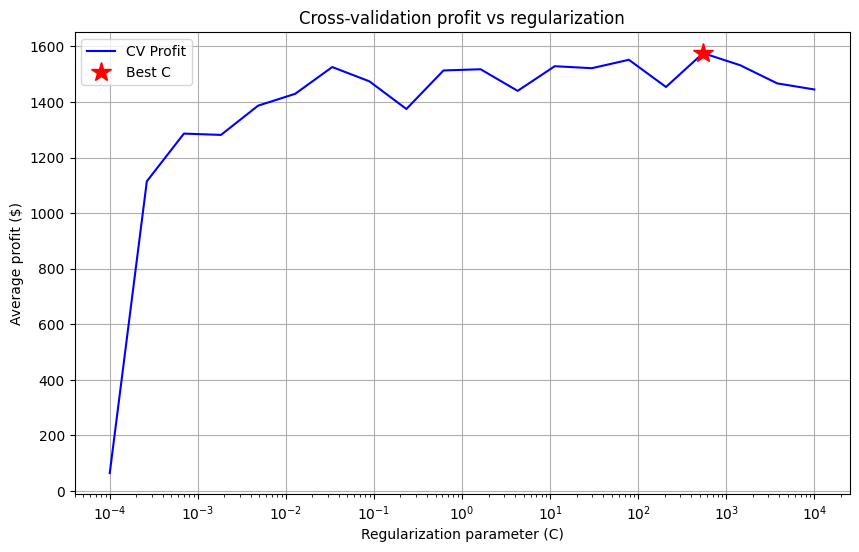

In [80]:
reg_params = np.logspace(-4, 4, 20)
cv_profits = []

for C in reg_params:
    fold_profits = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(X_train[numerical_features])
        X_test_num = scaler.transform(X_test[numerical_features])
        
        onehot = OneHotEncoder(handle_unknown='ignore')
        X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
        X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

        X_train_processed = np.hstack([X_train_num, X_train_cat])
        X_test_processed = np.hstack([X_test_num, X_test_cat])
        
        model = LogisticRegression(C=C, random_state=42)
        model.fit(X_train_processed, y_train)
        
        y_pred = model.predict(X_test_processed)
        
        n_calls = np.sum(y_pred == 1)
        n_true_positives = np.sum((y_pred == 1) & (y_test == 1))
        
        revenue_per_customer = np.random.uniform(0, 20, n_true_positives)
        revenue = np.sum(revenue_per_customer)
        cost = n_calls * 2
        profit = revenue - cost
        
        fold_profits.append(profit)
    
    cv_profits.append(np.mean(fold_profits))

best_C = reg_params[np.argmax(cv_profits)]
print(f"Best regularization parameter (C): {best_C:.4f}")
print(f"Maximum average profit: ${max(cv_profits):.2f}")

plt.figure(figsize=(10, 6))
plt.semilogx(reg_params, cv_profits, 'b-', label='CV Profit')
plt.semilogx(best_C, max(cv_profits), 'r*', markersize=15, label='Best C')
plt.xlabel('Regularization parameter (C)')
plt.ylabel('Average profit ($)')
plt.title('Cross-validation profit vs regularization')
plt.grid(True)
plt.legend()
plt.show()

да! мы примерное 100 даллоров смогли на этом заработать


In [90]:
n_runs = 5
best_Cs = []
max_profits = []

for run in range(n_runs):
    cv_profits = []
    for C in reg_params:
        fold_profits = []
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            scaler = StandardScaler()
            X_train_num = scaler.fit_transform(X_train[numerical_features])
            X_test_num = scaler.transform(X_test[numerical_features])
            
            onehot = OneHotEncoder(handle_unknown='ignore')
            X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
            X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

            X_train_processed = np.hstack([X_train_num, X_train_cat])
            X_test_processed = np.hstack([X_test_num, X_test_cat])
            
            model = LogisticRegression(C=C, random_state=42)
            model.fit(X_train_processed, y_train)
            
            y_pred = model.predict(X_test_processed)
            
            n_calls = np.sum(y_pred == 1)
            n_true_positives = np.sum((y_pred == 1) & (y_test == 1))
            
            revenue_per_customer = np.random.uniform(0, 20, n_true_positives)
            revenue = np.sum(revenue_per_customer)
            cost = n_calls * 2
            profit = revenue - cost
            
            fold_profits.append(profit)
        
        cv_profits.append(np.mean(fold_profits))
    
    best_Cs.append(reg_params[np.argmax(cv_profits)])
    max_profits.append(max(cv_profits))

print("\nResults from multiple runs:")
for i in range(n_runs):
    print(f"Run {i+1}: Best C = {best_Cs[i]:.4f}, Max profit = ${max_profits[i]:.2f}")

print(f"\nMean best C: {np.mean(best_Cs):.4f} ± {np.std(best_Cs):.4f}")
print(f"Mean max profit: ${np.mean(max_profits):.2f} ± ${np.std(max_profits):.2f}")



Results from multiple runs:
Run 1: Best C = 206.9138, Max profit = $1572.09
Run 2: Best C = 0.0336, Max profit = $1521.92
Run 3: Best C = 29.7635, Max profit = $1616.78
Run 4: Best C = 78.4760, Max profit = $1565.07
Run 5: Best C = 545.5595, Max profit = $1545.60

Mean best C: 172.1493 ± 199.6577
Mean max profit: $1564.29 ± $31.50


по результам видно, что у нас:
- Различие в результатах при каждом запуске, наш коэффициент бывает случаем и зависит от фолда
- Отсутствие стабильного "лучшего" коэффициента C, разброс значений значителен (172.1493±199.6577), что говорит о том, что не существует одного фиксированного коэффициента, который постоянно максимизирует прибыль, скорее всего у нас не выпуклая функция прибыли.
- Закономерность в максимальной прибыли: Несмотря на значительную вариацию C, максимальная прибыль более стабильна (1564.29±31.50). Это может свидетельствовать о том, что область значений C, дающих близкие к максимальным результаты, довольно широка.


__Ключевая метрика__ 

Если основная цель — сокращение ненужных расходов на звонки, то бизнес-метрика (profit) будет пропорциональна precision.
Если цель — максимизация охвата клиентов, то бизнес-метрика будет пропорциональна recall.

В таком случае, я бы выбрала F1, потому что кажется оба компонента важны.


Настройка порога бинаризации на кросс-валидации 

In [93]:
thresholds = np.arange(0, 1.01, 0.01)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_C = 0.01
clf = LogisticRegression(C=best_C, random_state=42)

threshold_profits = []

for threshold in thresholds:
    fold_profits = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
        
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(X_train[numerical_features])
        X_test_num = scaler.transform(X_test[numerical_features])
        
        onehot = OneHotEncoder(handle_unknown='ignore')
        X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
        X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

        X_train_processed = np.hstack([X_train_num, X_train_cat])
        X_test_processed = np.hstack([X_test_num, X_test_cat])
        
        clf.fit(X_train_processed, y_train)
        
        y_proba = clf.predict_proba(X_test_processed)[:, 1]
        
        y_pred = (y_proba >= threshold).astype(int)
        
        n_calls = np.sum(y_pred == 1)
        n_true_positives = np.sum((y_pred == 1) & (y_test == 1))
        
        revenue_per_customer = np.random.uniform(0, 20, n_true_positives)
        revenue = np.sum(revenue_per_customer)
        cost = n_calls * 2
        profit = revenue - cost
        
        fold_profits.append(profit)
    
    threshold_profits.append(np.mean(fold_profits))

best_threshold = thresholds[np.argmax(threshold_profits)]
max_profit = max(threshold_profits)

print(f"Best threshold: {best_threshold:.2f}")
print(f"Max profit with optimal threshold: ${max_profit:.2f}")

Best threshold: 0.20
Max profit with optimal threshold: $2882.98


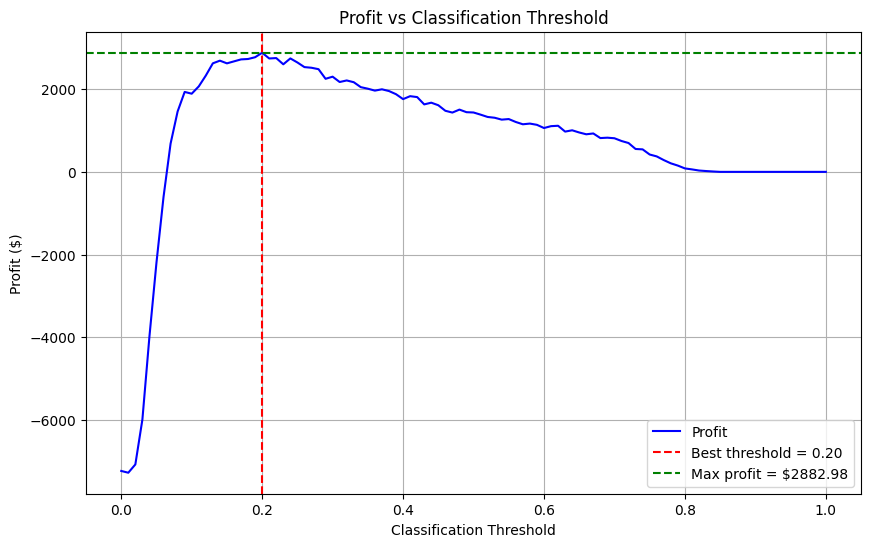

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, threshold_profits, 'b-', label='Profit')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.axhline(y=max_profit, color='g', linestyle='--', label=f'Max profit = ${max_profit:.2f}')
plt.xlabel('Classification Threshold')
plt.ylabel('Profit ($)')
plt.title('Profit vs Classification Threshold')
plt.grid(True)
plt.legend()
plt.show()



Я запустила несколько раз, примерно вот это заметила:
- лучший порог находится в районе среднего вероятностного значения.
думаю из-за того, что данные сбалансированные, и модель не может предсказать какой-то из классов лучше другого.

Ванильная логит регрессия

In [95]:
from scipy.stats import ttest_rel

default_model = LogisticRegression(random_state=42)
optimized_model = LogisticRegression(C=best_C, random_state=42)

default_profits = []
optimized_profits = []

for train_idx, val_idx in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_fold[numerical_features])
    X_val_num = scaler.transform(X_val_fold[numerical_features])
    
    onehot = OneHotEncoder(handle_unknown='ignore')
    X_train_cat = onehot.fit_transform(X_train_fold[categorical_features]).toarray()
    X_val_cat = onehot.transform(X_val_fold[categorical_features]).toarray()

    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_val_processed = np.hstack([X_val_num, X_val_cat])
    
    default_model.fit(X_train_processed, y_train_fold)
    default_probs = default_model.predict_proba(X_val_processed)[:, 1]
    default_preds = (default_probs >= 0.5).astype(int)
    
    n_calls = np.sum(default_preds == 1)
    n_true_positives = np.sum((default_preds == 1) & (y_val_fold == 1))
    revenue_per_customer = np.random.uniform(0, 20, n_true_positives)
    revenue = np.sum(revenue_per_customer)
    cost = n_calls * 2
    default_profit = revenue - cost
    default_profits.append(default_profit)
    
    optimized_model.fit(X_train_processed, y_train_fold)
    optimized_probs = optimized_model.predict_proba(X_val_processed)[:, 1]
    optimized_preds = (optimized_probs >= best_threshold).astype(int)
    
    n_calls = np.sum(optimized_preds == 1)
    n_true_positives = np.sum((optimized_preds == 1) & (y_val_fold == 1))
    revenue_per_customer = np.random.uniform(0, 20, n_true_positives)
    revenue = np.sum(revenue_per_customer)
    cost = n_calls * 2
    optimized_profit = revenue - cost
    optimized_profits.append(optimized_profit)

default_mean = np.mean(default_profits)
default_std = np.std(default_profits)
optimized_mean = np.mean(optimized_profits)
optimized_std = np.std(optimized_profits)

print("Default model profits:")
print(f"Mean: ${default_mean:.2f}")
print(f"Std: ${default_std:.2f}")
print("\nOptimized model profits:")
print(f"Mean: ${optimized_mean:.2f}") 
print(f"Std: ${optimized_std:.2f}")

t_stat, p_value = ttest_rel(optimized_profits, default_profits)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant improvement at α=0.05: {p_value < 0.05}")

Default model profits:
Mean: $1513.34
Std: $213.05

Optimized model profits:
Mean: $2810.05
Std: $229.61

t-statistic: 13.6180
p-value: 0.0002
Significant improvement at α=0.05: True


Результаты статистического теста (парного t-критерия) показали, что оптимизированная модель значительно улучшает бизнес-метрику по сравнению с дефолтной логистической регрессией. При среднем значении прибыли $2810.05 против $1513.34 и низком p-значении (0.0002), значительно меньшем уровня значимости $alpha$=0.05, можно с высокой уверенностью утверждать, что улучшение является статистически значимым.